In [1]:
import sys
sys.path.append("/home/pervinco/DL-workspace/VISION/detection")

import torch
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from albumentations.pytorch import ToTensorV2

In [2]:
def get_transform(img_size):
    transform = A.Compose([
        A.Resize(img_size, img_size),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2), p=0.5)
        ], p=1),

        # A.ElasticTransform(alpha=1.0, sigma=15.0, alpha_affine=50.0, interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False, same_dxdy=False, p=0.4),

        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)
        ], p=0.7),
        
        A.OneOf([
            A.Blur(p=0.2), 
            A.GaussianBlur(p=0.2), 
            A.GlassBlur(p=0.2), 
            A.MotionBlur(p=0.2), 
            A.GaussNoise(p=0.2)
        ], p=0.5),
        
        # A.OneOf([
        #     A.RandomSnow(p=0.5),
        #     A.RandomShadow(p=0.5)
        # ], p=0.5),

        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # ToTensorV2(),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=[]))

    return transform

In [3]:
df = pd.read_csv("./train.csv")

image_path = df.iloc[0, 0]
label_path = df.iloc[0, 1]

In [4]:
boxes = []
with open(label_path) as f:
    for label in f.readlines():
        class_label, x, y, width, height = [float(x) if float(x) != int(float(x)) else int(x) for x in label.replace("\n", "").split()]
        boxes.append([class_label, x, y, width, height])

image = Image.open(image_path)
boxes = torch.tensor(boxes)

In [5]:
transform = get_transform(448)
class_labels = boxes[:, 0]
box_coords = boxes[:, 1:]

transformed = transform(image=np.array(image), bboxes=box_coords)
image = transformed['image']
transformed_boxes = transformed['bboxes']

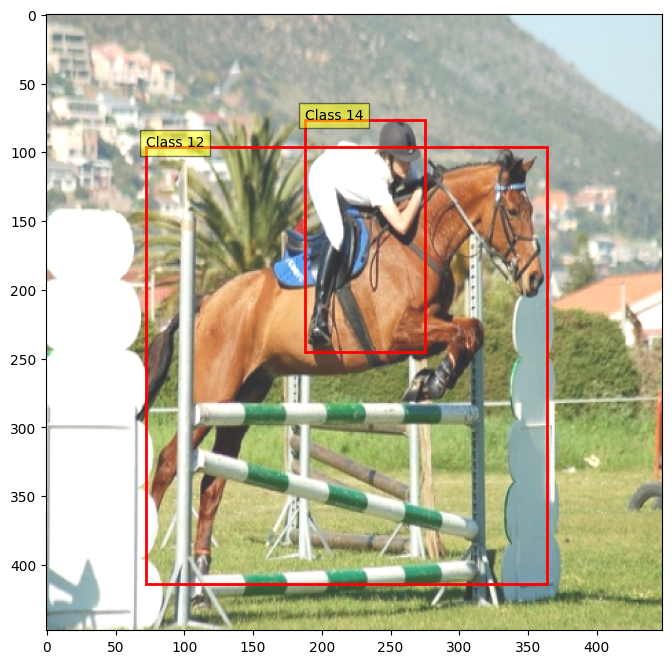

In [6]:
def draw_boxes(image, boxes, class_labels, img_size=448):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(boxes, class_labels):
        x_center, y_center, w, h = box
        xmin = (x_center - w / 2) * img_size
        xmax = (x_center + w / 2) * img_size
        ymin = (y_center - h / 2) * img_size
        ymax = (y_center + h / 2) * img_size

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class {int(label)}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

    plt.show()

np_image = np.array(image)
draw_boxes(np_image, transformed_boxes, class_labels.numpy())